In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from importlib import reload
import random
from tqdm import trange, tqdm
import seaborn as sns
from sklearn.metrics import accuracy_score
sns.set_style('whitegrid')

import mnist_utils as mut

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
reload(mut)

<module 'mnist_utils' from '/Users/edoardo/code/ai-for-fun/mnist/mnist_utils.py'>

In [4]:
W, H = mut.W, mut.H  # size of the image
X_train_raw, y_train_raw, X_test_raw, y_test_raw = mut.load_data()

In [5]:
mut.print_shapes(X_train_raw, y_train_raw, X_test_raw, y_test_raw)

Images train size:  (60000, 28, 28)
Labels train size:  (60000,)
Images test size:  (10000, 28, 28)
Labels test size:  (10000,)


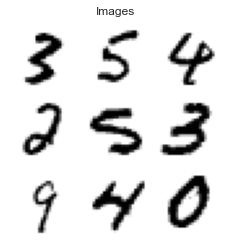


Labels:
 [[3 5 4]
 [2 5 3]
 [9 4 0]]


In [6]:
# Show random samples in a grid
mut.plot_random_grid(X_train_raw, y_train_raw, grid_n=3)

In [7]:
X_train = torch.tensor(X_train_raw / 255).float()
X_test = torch.tensor(X_test_raw / 255).float()
y_train = torch.tensor(y_train_raw).long()
y_test = torch.tensor(y_test_raw).long()

## Findings
### MLP model (MLPNet)
* 100 epochs of random batches give the same result of 100 ordered batches (~88%)
* with same amount of iterations as sklearn I can match the results (~98%)

### Convolution model (ConvNet)
* if a layer is initialized in the first forward pass performance is worse (94% -> 91%)

In [8]:
class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.l1 = nn.Linear(W * H, 200)
        self.l2 = nn.Linear(200, 50)
        self.l3 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = x.view(-1, W * H)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x


class ConvNet(nn.Module):
    def __init__(self, debug=False):
        super(ConvNet, self).__init__()
        self.debug = debug
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1_out = 120
        self.fc1 = nn.Linear(256, self.fc1_out)
        self.fc2 = nn.Linear(self.fc1_out, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = x.view(-1, 1, W, H)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        if self.debug:
            print('Out of conv: ', x.shape)

        conv_out_size = np.prod(x.shape[1:])
        
        if self.debug:
            print('conv_out_size: ', conv_out_size)
        
        x = x.view(-1, conv_out_size)
        
        if self.debug:
            print('After reshape: ', x.shape)
        
        if self.fc1 is None:
            self.fc1 = nn.Linear(conv_out_size, self.fc1_out)
        
        x = F.relu(self.fc1(x))
        
        if self.debug:
            print('After fc1: ', x.shape)
        
        x = F.relu(self.fc2(x))
        
        if self.debug:
            print('After fc1: ', x.shape)
        
        x = self.fc3(x)
        return x


In [9]:
debug_model = ConvNet(debug=True)
sample = X_train[:10]
sout = debug_model(X_train)

print('OUT:', sout.shape)
print('\n', sout)

Out of conv:  torch.Size([60000, 16, 4, 4])
conv_out_size:  256
After reshape:  torch.Size([60000, 256])
After fc1:  torch.Size([60000, 120])
After fc1:  torch.Size([60000, 84])
OUT: torch.Size([60000, 10])

 tensor([[ 0.0146,  0.0124,  0.0869,  ..., -0.0517, -0.0171,  0.0167],
        [ 0.0146,  0.0116,  0.0848,  ..., -0.0472, -0.0103,  0.0230],
        [ 0.0160,  0.0186,  0.0898,  ..., -0.0593, -0.0110,  0.0195],
        ...,
        [ 0.0163,  0.0125,  0.0877,  ..., -0.0477, -0.0087,  0.0162],
        [ 0.0089,  0.0178,  0.0882,  ..., -0.0512, -0.0238,  0.0251],
        [ 0.0127,  0.0153,  0.0869,  ..., -0.0412, -0.0145,  0.0197]],
       grad_fn=<AddmmBackward>)


In [10]:
import sys
sys.version

'3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]'

In [11]:
# net = MLPNet()
net = ConvNet()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

batch_size = 200

loss_vec, acc_vec = [], []

all_idx = np.arange(len(X_train))
random.shuffle(all_idx)
batch_idxs = np.array_split(all_idx, np.ceil(len(X_train) / batch_size))

# t = trange(100)
# for epoch in t:
#     batch_idx = np.random.randint(0, len(X_train_torch), size=(batch_size))

for epoch in range(5):
    for batch_idx in (t := tqdm(batch_idxs)):

        X = X_train[batch_idx]
        y = y_train[batch_idx]

        optimizer.zero_grad()
        
        outputs = net(X)
        this_loss = criterion(outputs, y)
        this_loss.backward()
        optimizer.step()

        y_pred_batch = np.argmax(outputs.detach().numpy(), axis=1)
        loss = this_loss.item()
        acc = accuracy_score(y, y_pred_batch)

        t.set_description('Epoch: %d, Loss: %.3f, Acc: %.2f' % (epoch + 1, loss, acc))

        loss_vec.append(loss)
        acc_vec.append(acc)


Epoch: 5, Loss: 0.060, Acc: 0.97: 100%|██████████| 300/300 [00:07<00:00, 38.17it/s]


In [12]:
test_out = net(X_test)
test_loss = criterion(test_out, y_test)

y_pred = np.argmax(test_out.detach().numpy(), axis=1)

print('Model prarmeters:', sum(p.numel() for p in net.parameters()), '\n')
mut.print_accuracy(y_test, y_pred)

Model prarmeters: 44426 

Accuracy 0: 99.59 %
Accuracy 1: 99.74 %
Accuracy 2: 97.58 %
Accuracy 3: 99.41 %
Accuracy 4: 98.98 %
Accuracy 5: 96.75 %
Accuracy 6: 98.96 %
Accuracy 7: 98.74 %
Accuracy 8: 96.2 %
Accuracy 9: 95.84 %

Total Accuracy: 98.21 %


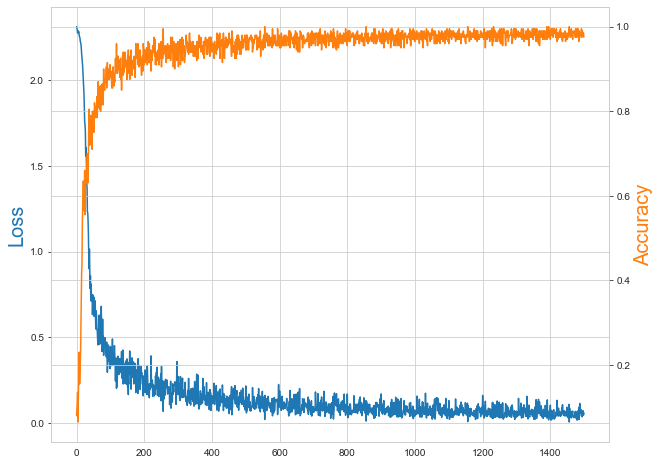

In [15]:
cp = sns.color_palette()
fontsize = 20
fig, ax1 = plt.subplots(figsize=(10, 8))

ax1.plot(loss_vec)
ax1.set_ylabel('Loss', c=cp[0], fontsize=fontsize)
ax2 = ax1.twinx()
ax2.plot(acc_vec, c=cp[1])
ax2.set_ylabel('Accuracy', c=cp[1], fontsize=fontsize)
plt.show()

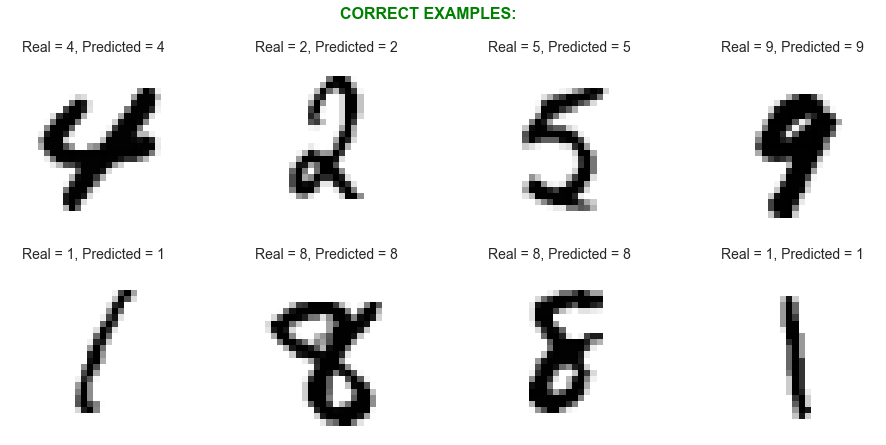

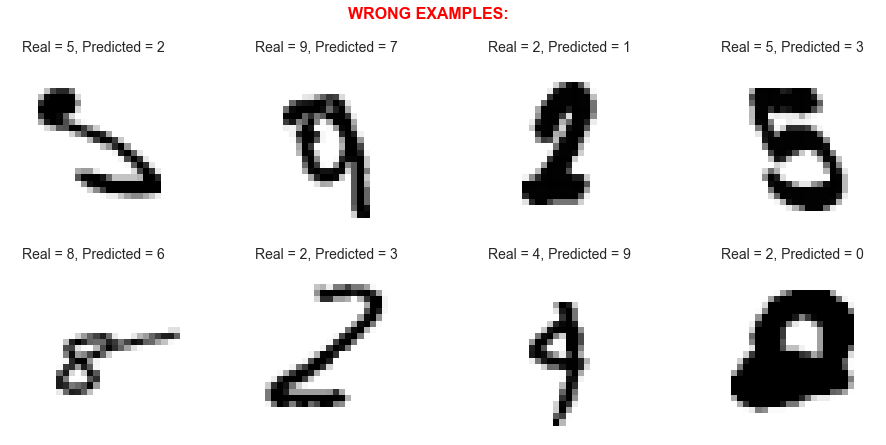

In [16]:
mut.plot_correct_and_wrong(X_test_raw, y_test_raw, y_pred)